Datadet from https://www.kaggle.com/datasets/jangedoo/utkface-new/data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
path = Path("UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

23708
['75_0_0_20170111201111541.jpg.chip.jpg', '35_0_2_20170116173652735.jpg.chip.jpg', '26_1_1_20170116232602440.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [5]:
image_path[:5]

['36_1_1_20170117165628076.jpg.chip.jpg',
 '76_1_2_20170110182935621.jpg.chip.jpg',
 '49_0_0_20170104205813820.jpg.chip.jpg',
 '30_0_2_20170117141818577.jpg.chip.jpg',
 '34_1_2_20170116171155691.jpg.chip.jpg']

# From Unstructured data to Structured data

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [7]:
df.head()

,image,age,gender
0,36_1_1_20170117165628076.jpg.chip.jpg,36,1
1,76_1_2_20170110182935621.jpg.chip.jpg,76,1
2,49_0_0_20170104205813820.jpg.chip.jpg,49,0
3,30_0_2_20170117141818577.jpg.chip.jpg,30,0
4,34_1_2_20170116171155691.jpg.chip.jpg,34,1


In [8]:
gender_dict = {0:"Male",1:"Female"}

In [9]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [10]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


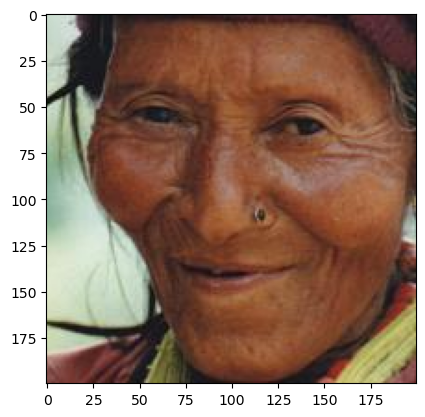

In [11]:
img = Image.open("UTKFace/"+df.image[1])
plt.imshow(img)

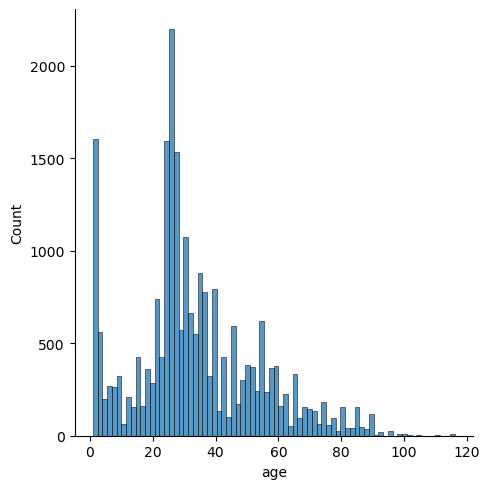

In [12]:
sns.displot(df.age)

# Plotting Images

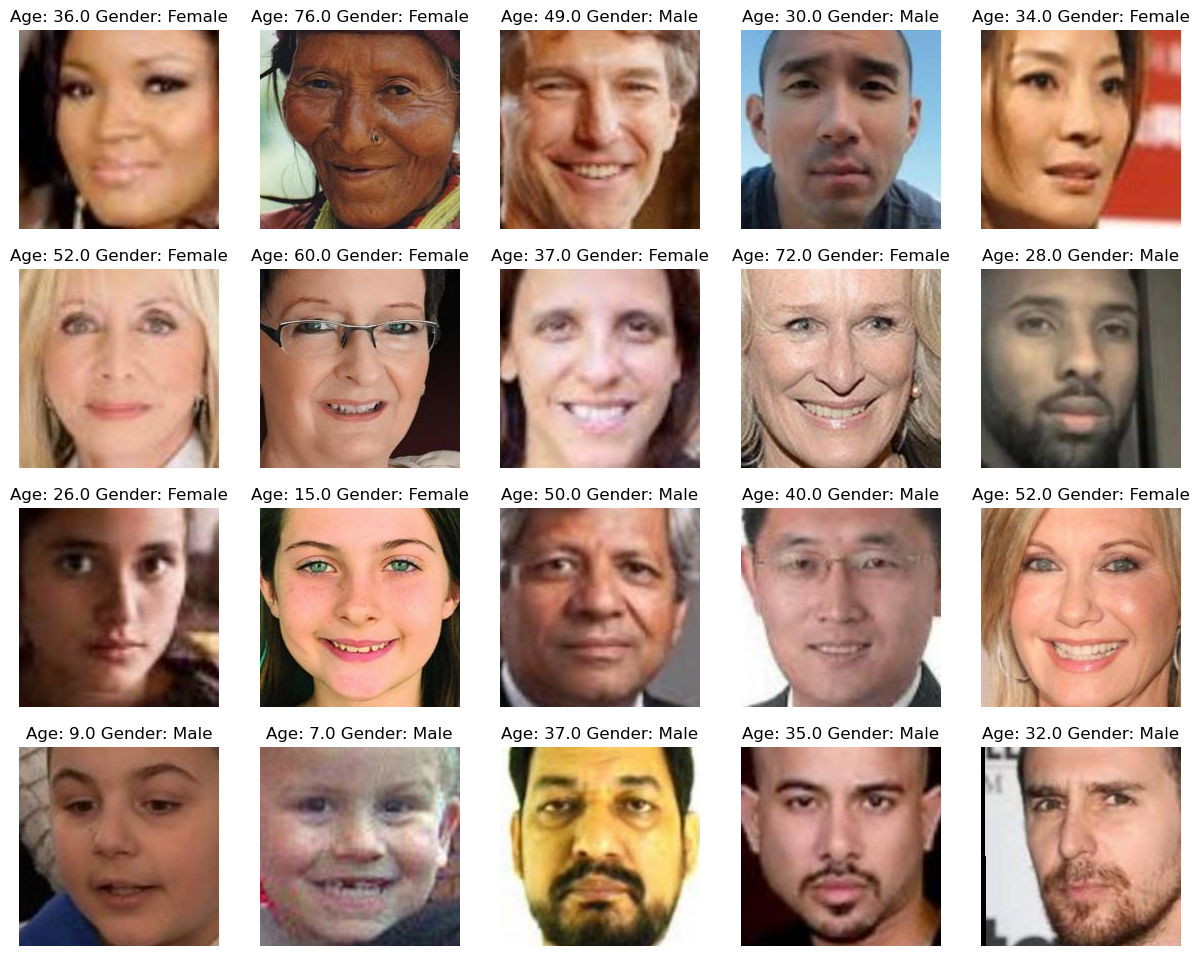

In [13]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [14]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [15]:
train.head()

,image,age,gender
18199,27_1_0_20170117142744825.jpg.chip.jpg,27.0,1
19557,29_0_1_20170114030901209.jpg.chip.jpg,29.0,0
20132,40_0_0_20170117130718950.jpg.chip.jpg,40.0,0
11849,19_1_4_20170103233712235.jpg.chip.jpg,19.0,1
2100,55_0_1_20170117165048545.jpg.chip.jpg,55.0,0


# Extracting Features

In [16]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, color_mode="grayscale")
    img = img.resize((48, 48), Image.LANCZOS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 48, 48, 1)

In [17]:
x_train.shape

(3556, 48, 48, 1)

# Normalizing data

In [18]:
x_train = x_train/255

In [19]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [20]:
input_size = (48, 48, 1)

# Creating model

Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but I have implemented CNN with little Skip connections (shortcut). 

In [21]:
inputs = Input((input_size))
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
x = BatchNormalization(axis = 3)(x)
x = MaxPooling2D((3, 3))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

dense_1 = Dense(256, activation='relu')(x)
dense_2 = Dense(256, activation='relu' )(x)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

2024-05-21 11:09:46.047687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 11:09:46.606901: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 11:09:46.607015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 11:09:46.635477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 11:09:46.635660: I external/local_xla/xla/stream_executor

In [22]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 46, 46, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 46, 46, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)           0         ['batch_normalization[0][0

In [26]:
checkpoint = ModelCheckpoint(
    "age_gender_model.h5", monitor="val_gender_output_accuracy", verbose=1, save_best_only=True)

# Training the model

In [27]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 16, epochs=20, validation_split= 0.1, callbacks=checkpoint)

Epoch 1/20


2024-05-21 11:16:31.772900: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-21 11:16:35.601338: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6af44af860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 11:16:35.601438: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-21 11:16:35.769250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716282996.004011    2006 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/200 [============================>.] - ETA: 0s - loss: 16.5540 - gender_output_loss: 0.7035 - age_output_loss: 15.8505 - gender_output_accuracy: 0.6011 - age_output_accuracy: 0.0487
Epoch 1: val_gender_output_accuracy improved from -inf to 0.71629, saving model to age_gender_model.h5
200/200 [==============================] - 14s 20ms/step - loss: 16.5302 - gender_output_loss: 0.7025 - age_output_loss: 15.8277 - gender_output_accuracy: 0.6019 - age_output_accuracy: 0.0491 - val_loss: 28.3663 - val_gender_output_loss: 0.6682 - val_age_output_loss: 27.6981 - val_gender_output_accuracy: 0.7163 - val_age_output_accuracy: 0.0618
Epoch 2/20
  1/200 [..............................] - ETA: 2s - loss: 12.8254 - gender_output_loss: 0.5508 - age_output_loss: 12.2746 - gender_output_accuracy: 0.8750 - age_output_accuracy: 0.0000e+00

/home/marcus/conda/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/200 [============================>.] - ETA: 0s - loss: 12.8863 - gender_output_loss: 0.5616 - age_output_loss: 12.3247 - gender_output_accuracy: 0.7142 - age_output_accuracy: 0.0443
Epoch 2: val_gender_output_accuracy improved from 0.71629 to 0.75562, saving model to age_gender_model.h5
200/200 [==============================] - 3s 16ms/step - loss: 12.8764 - gender_output_loss: 0.5621 - age_output_loss: 12.3142 - gender_output_accuracy: 0.7138 - age_output_accuracy: 0.0441 - val_loss: 17.1166 - val_gender_output_loss: 0.6119 - val_age_output_loss: 16.5047 - val_gender_output_accuracy: 0.7556 - val_age_output_accuracy: 0.0618
Epoch 3/20
196/200 [============================>.] - ETA: 0s - loss: 11.6433 - gender_output_loss: 0.5399 - age_output_loss: 11.1034 - gender_output_accuracy: 0.7315 - age_output_accuracy: 0.0469
Epoch 3: val_gender_output_accuracy improved from 0.75562 to 0.76685, saving model to age_gender_model.h5
200/200 [==============================] - 3s 16ms/step - l

In [30]:
model.save('age_gender_model.h5')

/home/marcus/conda/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-05-21 10:26:49.358727: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.


# Visualizing loss

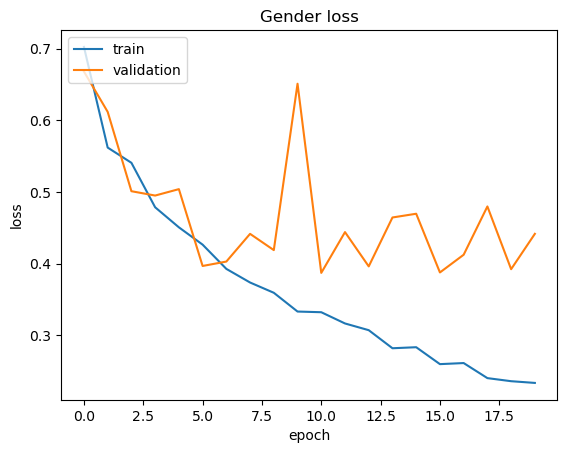

In [28]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

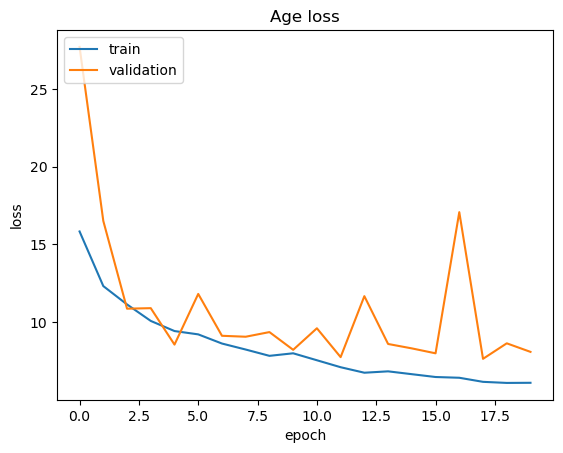

In [29]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Female  Age =  26.0
1/1 [==============================] - 2s 2s/step
Prediction: Gender =  Female  Age =  25


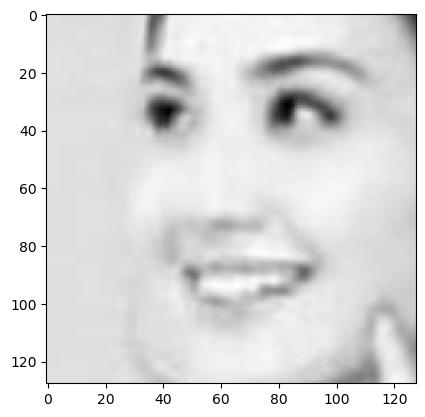

In [31]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

Original: Gender =  Female  Age =  37.0
1/1 [==============================] - 0s 40ms/step
Prediction: Gender =  Female  Age =  39


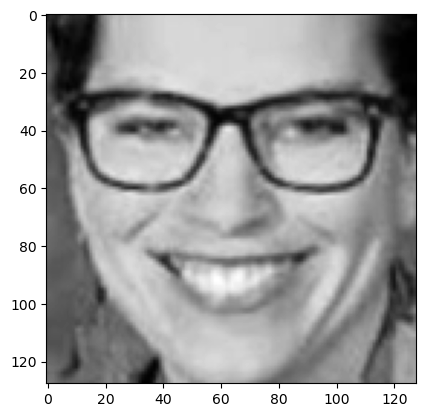

In [32]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')